In [30]:
from rich import print
from rich import pretty
pretty.install()
from icecream import ic
from rich.console import Console
console = Console()
from IPython.display import Markdown

import os
from pathlib import Path
import pathlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from keras.callbacks import ModelCheckpoint # to save models
from keras.models import load_model # load model from disk
from scipy.stats import norm
from embed_sources import create_sentence_embedding
from sentence_transformers import SentenceTransformer


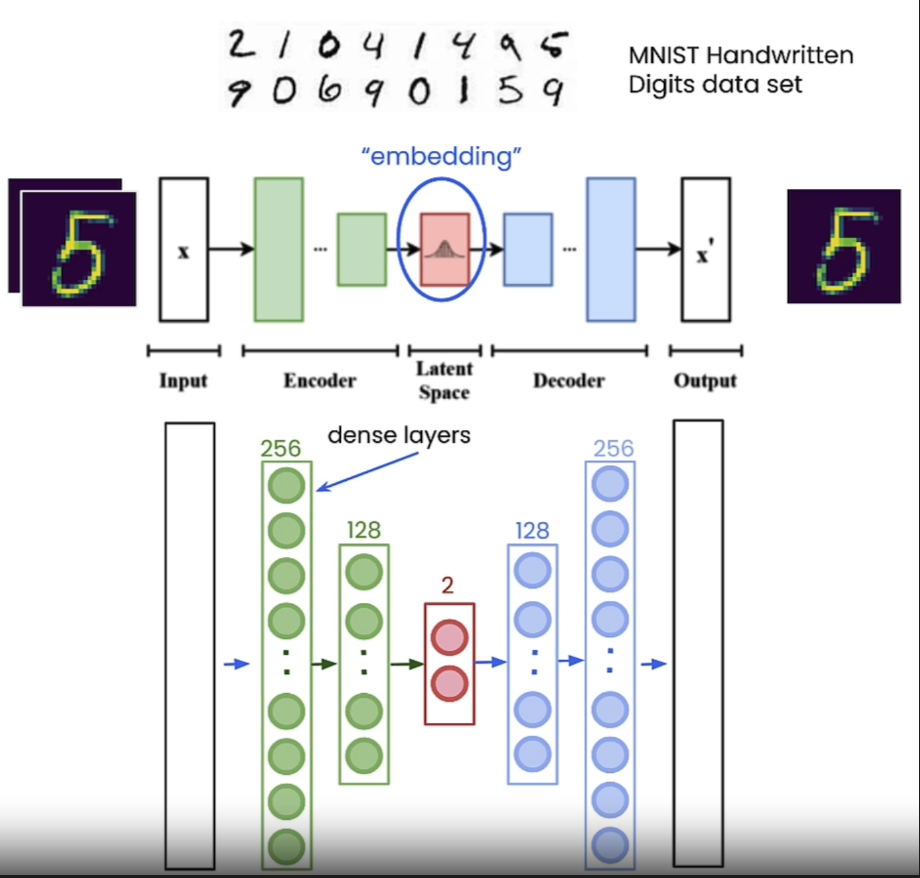{:width='500px'}

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()


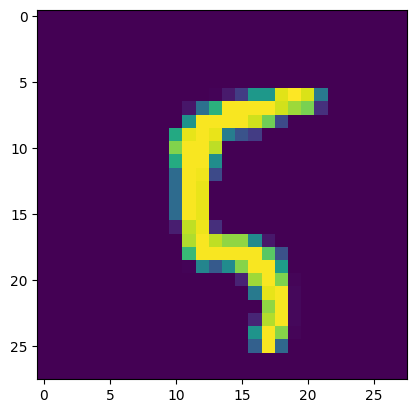

In [3]:
# lets view one of the images
plt.imshow(x_tr[100])


In [4]:
def print_shape(X_train = x_tr, y_train = y_tr, X_test = x_te, y_test = y_te):
    print(f"""
    The shape of X_train is {X_train.shape}\n
    The shape of y_train is {y_train.shape}\n
    The shape of X_test is {X_test.shape}\n
    The shape of y_test is {y_test.shape}\n
    """)
    return None


In [5]:
print_shape()


The shape of X_train is (60000, 28, 28)

    The shape of y_train is (60000,)

    The shape of X_test is (10000, 28, 28)

    The shape of y_test is (10000,)

In [6]:
# normalize the image pixel to between 0 - 255 and reshape the array to a 2-dimensional array
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

print_shape(x_tr_flat, y_tr, x_te_flat, y_te)


The shape of X_train is (60000, 784)

    The shape of y_train is (60000,)

    The shape of X_test is (10000, 784)

    The shape of y_test is (10000,)

In [7]:
# create a sampling function to be able to grab number of images randomly during training.
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps


In [8]:
# set the network parameters
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2


In [9]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])


In [10]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)


In [11]:
# variational autoencode (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(
    inputs_flat,
    outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(
    K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat -1 , axis = -1)

vae_flat_loss = reconstruction_loss + kl_loss

# Build model
# ensure that the reconstructed ouputs are as close to the inputs as possible
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer = 'adam')


In [18]:
checkpoint_path = "./vae_checkpoint.h5"  # Path to save the model file
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# train and save the model with minimum loss
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1,
    callbacks=[checkpoint]
)


In [19]:
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1,
    callbacks=[checkpoint]
)

# vae_flat.fit(
#     x_tr_flat,
#     shuffle=True,
#     epochs=n_epoch,
#     batch_size=batch_size,
#     validation_data=(x_te_flat, None),
#     verbose=1
# )


Epoch 1/50
600/600 [==============================] - 5s 8ms/step - loss: 131.5014 - val_loss: 135.3946
Epoch 2/50
 21/600 [>.............................] - ETA: 3s - loss: 130.6133

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 5s 8ms/step - loss: 131.3721 - val_loss: 134.9087
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 131.2648 - val_loss: 134.5038
Epoch 4/50
600/600 [==============================] - 4s 7ms/step - loss: 131.4324 - val_loss: 135.0188
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 131.4530 - val_loss: 134.8001
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 131.1519 - val_loss: 134.7976
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 131.1874 - val_loss: 134.8845
Epoch 8/50
600/600 [==============================] - 3s 6ms/step - loss: 131.2833 - val_loss: 135.0855
Epoch 9/50
600/600 [==============================] - 3s 6ms/step - loss: 131.3086 - val_loss: 135.1996
Epoch 10/50
600/600 [==============================] - 3s 6ms/step - loss: 131.2800 - val_loss: 135.1552
Epoch 11/50
600/600 [==============================] - 3s 6ms/step - loss:

<keras.src.callbacks.History object at 0x7f142af75960>

In [20]:
# load saved model from disk
saved_vae = load_model(checkpoint_path)


In [24]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder


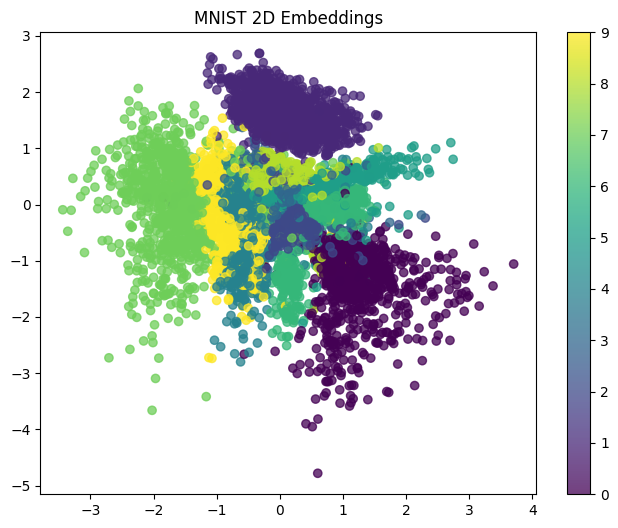

In [25]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()


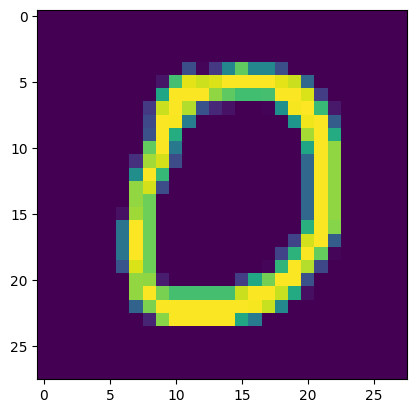

In [26]:
# let us now compare vector embedding
plt.imshow(x_te_flat[10].reshape(28, 28))


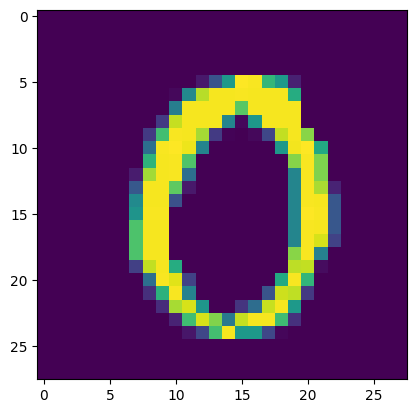

In [27]:
plt.imshow(x_te_flat[13].reshape(28,28));


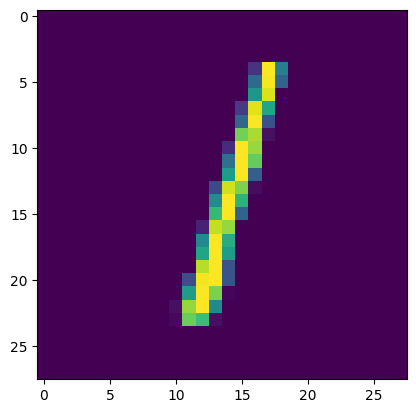

In [28]:
plt.imshow(x_te_flat[2].reshape(28,28));


In [29]:
# lookup vectors for each digits
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")


Embedding for the first ZERO is  [ 0.9403491 -1.2957155]

Embedding for the second ZERO is [ 0.81818414 -0.9939149 ]

Embedding for the ONE is         [0.2978968 1.8849428]

In [31]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']
model = SentenceTransformer("all-mpnet-base-v2")

# get the embedding of the query
sentence_embedding, _ = create_sentence_embedding(sentence, model, bert = False)


In [32]:
sentence_embedding.shape


(3, 768)

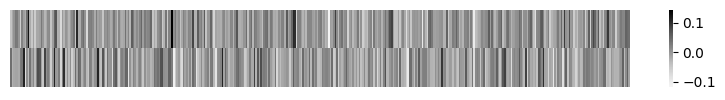

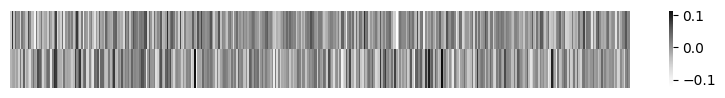

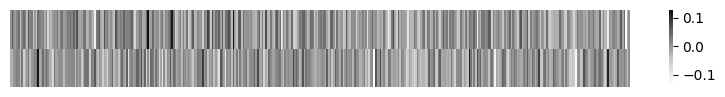

In [34]:
import seaborn as sns

sns.heatmap(sentence_embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(sentence_embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(sentence_embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()
